# Info
Name:  

    Gas_sepctra_insformation_content
    
Purpose:  

    Loads HiTRAN for NO2 and Ozone, and uses different fwhm to subsample and calculate the information content
    Adds random noise to sampling
  
Input:

    None
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - load_utils.py : for loading OMI HDF5 files
    - matplotlib
    - numpy
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - 
  
Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2019-06-14
    Modified: 

# Prepare python environment

In [1]:
%config InlineBackend.rc = {}
import matplotlib 
import os
matplotlib.rc_file(os.path.join(os.getcwd(),'file.rc'))
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import Sp_parameters as Sp
from load_utils import mat2py_time, toutc, load_ict
import load_utils as lu
import plotting_utils as pu
from path_utils import getpath
import hdf5storage as hs
from datetime import datetime
from scipy.interpolate import UnivariateSpline
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import scipy.stats as st
from scipy import integrate

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import hapi

HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


In [3]:
%matplotlib notebook

In [4]:
fp =getpath('4STAR_gas')

Return path named:  4STAR_gas /mnt/c/Users/sleblanc/Research/4STAR/gas/


# Load files

## Using the HAPI hitran python API

In [24]:
hapi.getHelp('tutorial')

-----------------------------------
This is a tutorial section of help.
-----------------------------------
Please choose the subject of tutorial:
    data      -  downloading the data and working with it
    spectra   -  calculating spectral functions
    plotting  -  visualizing data with matplotlib
    python    -  Python quick start guide


In [26]:
hapi.getHelp('data')



ACCESS YOUR DATA!

Welcome to tutorial on retrieving and processing the data from HITRANonline.


  ///////////////
 /// PREFACE ///
///////////////

HITRANonline API is a set of routines in Python which is aimed to 
provide a remote access to functionality and data given by a new project 
HITRANonline (http://hitranazure.cloudapp.net).

At the present moment the API can download, filter and process data on 
molecular and atomic line-by-line spectra which is provided by HITRANonline portal.

One of the major purposes of introducing API is extending a functionality 
of the main site, particularly providing a possibility to calculate several 
types of high- and low-resolution spectra based on a flexible HT lineshape. 

Each feature of API is represented by a Python function with a set of parameters 
providing a flexible approach to the task.


  ///////////////////////
 /// FEATURE SUMMARY ///
///////////////////////

1) Downloading line-by-line data from the HITRANonline site to local

In [27]:
hapi.db_begin('data')

Using data



In [32]:
hapi.getHelp(hapi.fetch)

Help on function fetch in module hapi:

fetch(TableName, M, I, numin, numax, ParameterGroups=[], Parameters=[])
    INPUT PARAMETERS: 
        TableName:   local table name to fetch in (required)
        M:           HITRAN molecule number       (required)
        I:           HITRAN isotopologue number   (required)
        numin:       lower wavenumber bound       (required)
        numax:       upper wavenumber bound       (required)
    OUTPUT PARAMETERS: 
        none
    ---
    DESCRIPTION:
        Download line-by-line data from HITRANonline server
        and save it to local table. The input parameters M and I
        are the HITRAN molecule and isotopologue numbers.
        This function results in a table containing single 
        isotopologue specie. To have multiple species in a 
        single table use fetch_by_ids instead.
    ---
    EXAMPLE OF USAGE:
        fetch('HOH',1,1,4000,4100)
    ---



In [39]:
hapi.fetch('NO2',0,1,29164,40798)

KeyError: (0, 1)

## Load the crosssection files directly

In [23]:
no2_xsc = []
len(no2_xsc)

0

In [ ]:
fname = fp+'no2/NO2_294.0_0.0_15002.0-42002.3_00.xsc'

In [79]:
def read_xsc(fname):
    'Reading function for xsc files. full file path at fname, returns dict with numpy'
    import numpy as np
    no2_xsc = []
    no2h = []
    with open(fname) as f:
        if len(no2_xsc) < 1:
            no2h = f.readline()
        l = f.readlines()
        l = [tl[:-1] for tl in l]
        ''.join(l).strip().split(' ')
        no2_xsc = np.array([float(g) for g in ''.join(l).strip().split(' ')])
    header = {'molecule':no2h[0:20].strip(),'wvn_min':float(no2h[20:30]),'wvn_max':float(no2h[30:40]),'N':int(no2h[40:47]),
              'T':float(no2h[47:54]),'P':float(no2h[54:60]),'max_xsc':float(no2h[60:70]),'resolution':float(no2h[70:75]),
              'name':no2h[75:90].strip(),'na':no2h[90:94],'broadener':no2h[94:97].strip(),'ref':int(no2h[97:100]),
              'xsc':no2_xsc}
    header['wv'] = np.linspace(header['wvn_min'],header['wvn_max'],header['N'])
    header['nm'] = 1.0/header['wv'] *10.0*1000.0*1000.0
    return header


In [80]:
no2 = read_xsc(fp+'no2/NO2_294.0_0.0_15002.0-42002.3_00.xsc')

In [81]:
no2

{'N': 27993,
 'P': 0.0,
 'T': 294.0,
 'broadener': 'air',
 'max_xsc': 8.395e-19,
 'molecule': 'NO2',
 'na': '    ',
 'name': 'NO2',
 'nm': array([666.57810066, 666.53524492, 666.49239469, ..., 238.09312442,
        238.08765655, 238.08218892]),
 'ref': 17,
 'resolution': 2.0,
 'wv': array([15001.993     , 15002.95757234, 15003.92214468, ...,
        42000.37285532, 42001.33742766, 42002.302     ]),
 'wvn_max': 42002.302,
 'wvn_min': 15001.993,
 'xsc': array([8.821e-21, 8.778e-21, 8.149e-21, ..., 9.242e-20, 1.248e-19,
        7.288e-20])}

<IPython.core.display.Javascript object>


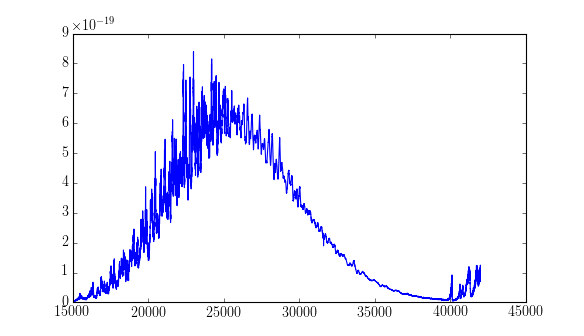

In [82]:
plt.figure()
plt.plot(no2['wv'],no2['xsc'])

<IPython.core.display.Javascript object>


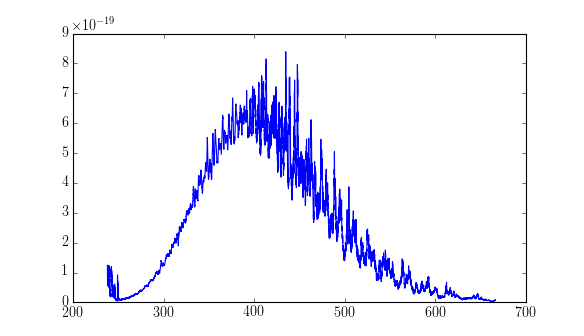

In [83]:
plt.figure()
plt.plot(no2['nm'],no2['xsc'])

## Make the Shannon information content function

In [99]:
def sic(p):
    'Shannon Information of probability distribution p'
    n = len(p)
    pd = p / np.sum(p)
    sic = np.nansum(pd*np.log2(pd)) * (-1.0)
    return sic

In [100]:
no2s = sic(no2['xsc'])

In [101]:
no2s

14.144229792013222


## Build the gaussian smoothing slit functions

In [104]:
def gaussian( x, u , s):
    return 1./np.sqrt( 2. * np.pi * s**2 ) * np.exp(-1.0/2.0*((x-u)/s)**2.0)


<IPython.core.display.Javascript object>


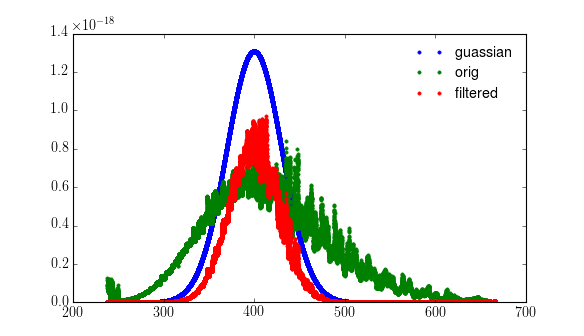

In [115]:
plt.figure()
plt.plot(no2['nm'],gaussian(no2['nm'],400.0,30.5)*0.0000000000000001,'.',label='guassian')
plt.plot(no2['nm'],no2['xsc'],'.',label='orig')
plt.plot(no2['nm'],gaussian(no2['nm'],400.0,30.5)*no2['xsc']*100.0,'.',label='filtered')
plt.legend(frameon=False)

In [122]:
integrate.simps(gaussian(no2['nm'],400.0,30.5),no2['nm'])

-0.9999999448194865

In [120]:
integrate.simps(gaussian(no2['nm'],400.0,30.5)*no2['xsc'],no2['nm'])

-5.62332662999015e-19

In [125]:
i4 = np.argmin(abs(no2['nm']-400.0))
no2['xsc'][i4],no2['nm'][i4]

(6.989e-19, 400.00343481600504)

In [130]:
def convolver(xsc,nm,fwhm):
    'function to go through the cross-section (xsc) and convolve a gaussian with full-width-half-max (fwhm), at the sampling grid (nm)'
    from scipy import integrate
    import numpy as np
    return np.array([integrate.simps(gaussian(nm,n,fwhm)*xsc,nm)*-1.0 for n in nm])

        
    

<IPython.core.display.Javascript object>


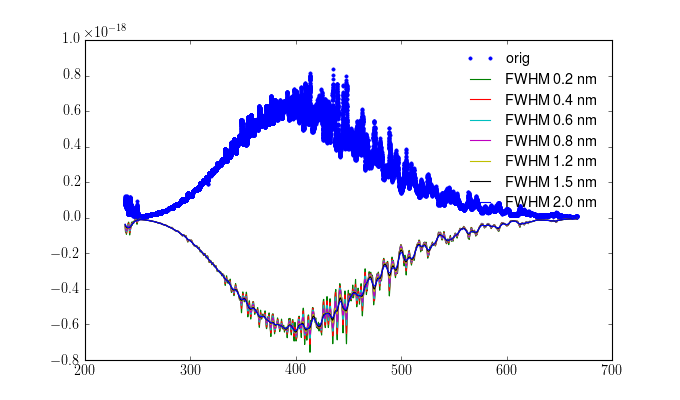

In [129]:
plt.figure()
plt.plot(no2['nm'],no2['xsc'],'.',label='orig')
plt.plot(no2['nm'],convolver(no2['xsc'],no2['nm'],0.2),label='FWHM 0.2 nm')
plt.plot(no2['nm'],convolver(no2['xsc'],no2['nm'],0.4),label='FWHM 0.4 nm')
plt.plot(no2['nm'],convolver(no2['xsc'],no2['nm'],0.6),label='FWHM 0.6 nm')
plt.plot(no2['nm'],convolver(no2['xsc'],no2['nm'],0.8),label='FWHM 0.8 nm')
plt.plot(no2['nm'],convolver(no2['xsc'],no2['nm'],1.2),label='FWHM 1.2 nm')
plt.plot(no2['nm'],convolver(no2['xsc'],no2['nm'],1.5),label='FWHM 1.5 nm')
plt.plot(no2['nm'],convolver(no2['xsc'],no2['nm'],2.0),label='FWHM 2.0 nm')
plt.legend(frameon=False)

In [150]:
fwhms = np.around(np.logspace(-1,0.75,20),2)

In [151]:
fwhms

array([0.1 , 0.12, 0.15, 0.19, 0.23, 0.29, 0.36, 0.44, 0.55, 0.67, 0.83,
       1.03, 1.27, 1.58, 1.95, 2.41, 2.98, 3.68, 4.55, 5.62])

In [152]:
subsamp = [convolver(no2['xsc'],no2['nm'],fw) for fw in fwhms]    

In [153]:
sub_sic = [sic(s) for s in subsamp]

<IPython.core.display.Javascript object>


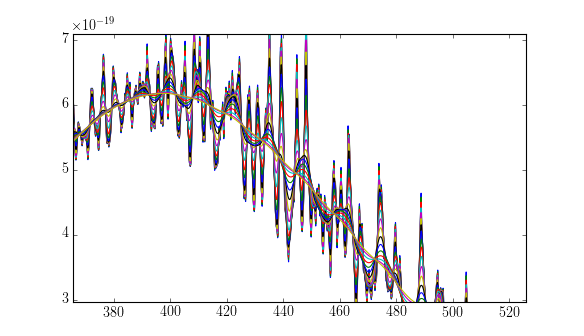

In [161]:
plt.figure()
plt.plot(no2['nm'],np.array(subsamp).T)

<IPython.core.display.Javascript object>


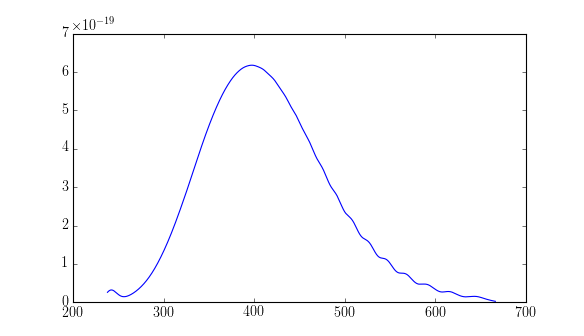

(14.155148286984438, 14.144229792013222)

In [165]:
plt.figure() 
plt.plot(no2['nm'],subsamp[-1])
sic(subsamp[-1]),sic(no2['xsc'])

<IPython.core.display.Javascript object>


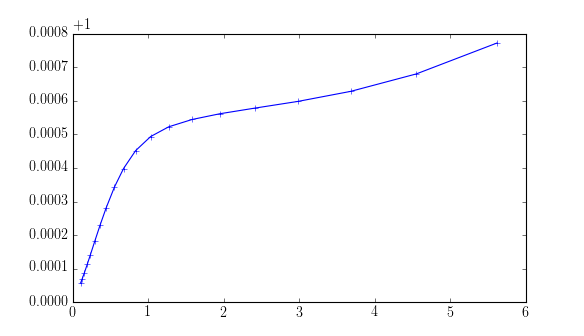

In [159]:
plt.figure()
plt.plot(fwhms, sub_sic/sic(no2['xsc']),'+-')

In [157]:
sic(no2['xsc'])

14.144229792013222

In [156]:
sic(gaussian(no2['nm'],400.0,2.0))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


9.06513495417367

## Add some white noise

In [135]:
snr = 1.0/1000.0
np.random.rand(len(no2['nm']))*no2['max_xsc']*snr

array([5.33208870e-22, 6.39391580e-22, 6.86646447e-22, ...,
       6.39660230e-22, 3.78466762e-22, 2.17066359e-22])

# Run analysis and prepare variables
Do some of the calculations to the data here

# Plotting
Present some fo the early plots here